In [1]:
import tensorflow.keras as keras
keras.__version__

"""
Allocate only as much GPU memory as needed for the runtime allocations.
"""
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Recurrent Neural Networks

### Feedforward networks
- no memory -- each input is processed independently, with no state kept in between inputs.
- show entire sequence to the network at once : turn it into a single data point.

### Recurrent Neural Networks (RNN)
- iterating through the sequence element
- each sequence element is a single data point
- maintaining a `state` containing information relative to what it has seen so far

In effect, an RNN is a type of neural network that has an internal `loop`. It reuses quantities computed during the previous iteration of the loop.


### Pseudocode for the RNN
```
for input_t in input_sequence:
    output_t = activation_function( dot(W, input_t) + dot(U, state_t) + b )
    state_t = output_t
```

## A simple recurrent layer in Keras

`SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence. This means that the SimpleRNN layer takes `inputs` of shape `(batch_size, timesteps, input_features)`. (The input to a layer is the output of immediate prior layer.)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: return either 

1. the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), 
2. only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). 

These two modes are controlled by the return_sequences constructor argument.

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you `have to get all intermediate layers to return full sequences`:

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))     # must return full sequences
model.add(SimpleRNN(32, return_sequences=True))     # must return full sequences
model.add(SimpleRNN(32, return_sequences=True))     # must return full sequences
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## IMDB movie review classification problem using RNN

In [5]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences (reviews)')
print(len(input_test), 'test sequences (reviews)')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences (reviews)
25000 test sequences (reviews)
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an Embedding layer and a SimpleRNN layer:

In [6]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 30s 189ms/step - loss: 0.6573 - acc: 0.5980 - val_loss: 0.5657 - val_acc: 0.7404
Epoch 2/10
157/157 [==============================] - 30s 190ms/step - loss: 0.4074 - acc: 0.8279 - val_loss: 0.3875 - val_acc: 0.8362
Epoch 3/10
157/157 [==============================] - 29s 185ms/step - loss: 0.2903 - acc: 0.8846 - val_loss: 0.3975 - val_acc: 0.8222
Epoch 4/10
157/157 [==============================] - 29s 185ms/step - loss: 0.2444 - acc: 0.9018 - val_loss: 0.4673 - val_acc: 0.8080
Epoch 5/10
157/157 [==============================] - 29s 185ms/step - loss: 0.1810 - acc: 0.9311 - val_loss: 0.3858 - val_acc: 0.8488
Epoch 6/10
157/157 [==============================] - 29s 186ms/step - loss: 0.1245 - acc: 0.9569 - val_loss: 0.4960 - val_acc: 0.8002
Epoch 7/10
157/157 [==============================] - 29s 185ms/step - loss: 0.0914 - acc: 0.9686 - val_loss: 0.5117 - val_acc: 0.8170
Epoch 8/10
157/157 [==============================] - 2

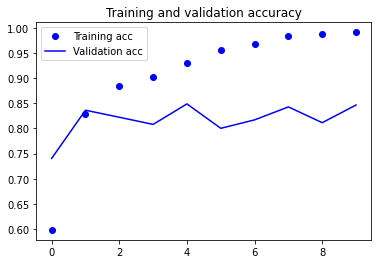

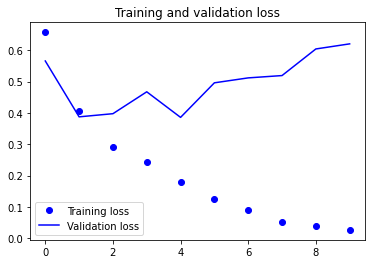

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Only upto 85% accuracy in validation. It doesnot performa very well for two reasons:

1. Our inputs only consider the first 500 words rather the full sequences.
2. SimpleRNN isn't very good at processsing long sequence, like text. 


Other types of recurrent layers perform much better. Let's take a look at some more advanced layers.

## Long short-term memory (LSTM) and GRU layers

In practice, you'll always use either `LSTM` or `GRU`, because `SimpleRNN` is generally too simplistic to be of real use. `SimpleRNN` hash a major issue: although it should theoretically be able to retain information about inputs seen many timesteps before, in practice, such long-term dependencies are impossible to learn. This is due to the `vanishing gradient problem`.

`LSTM` and `GRU` are designed to avoid the `vanishing gradient problem`. LSTM saves information for later, thus `preventing older signals from gradually vanishing during processing`.

## A concrete LSTM example in Keras

Set up a model using a LSTM layer and train it on the IMDB data.

In [9]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 5s 31ms/step - loss: 0.4890 - acc: 0.7731 - val_loss: 0.3826 - val_acc: 0.8512
Epoch 2/10
157/157 [==============================] - 5s 29ms/step - loss: 0.2997 - acc: 0.8842 - val_loss: 0.2791 - val_acc: 0.8892
Epoch 3/10
157/157 [==============================] - 5s 29ms/step - loss: 0.2375 - acc: 0.9114 - val_loss: 0.3621 - val_acc: 0.8602
Epoch 4/10
157/157 [==============================] - 4s 29ms/step - loss: 0.2037 - acc: 0.9247 - val_loss: 0.2873 - val_acc: 0.8888
Epoch 5/10
157/157 [==============================] - 5s 29ms/step - loss: 0.1769 - acc: 0.9352 - val_loss: 0.3336 - val_acc: 0.8760
Epoch 6/10
157/157 [==============================] - 5s 30ms/step - loss: 0.1599 - acc: 0.9437 - val_loss: 0.3522 - val_acc: 0.8750
Epoch 7/10
157/157 [==============================] - 5s 30ms/step - loss: 0.1422 - acc: 0.9505 - val_loss: 0.3194 - val_acc: 0.8752
Epoch 8/10
157/157 [==============================] - 5s 30ms/step - 

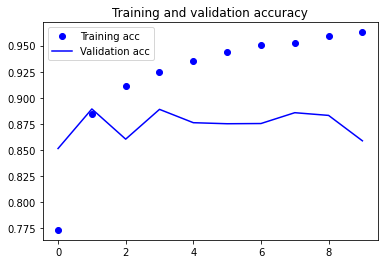

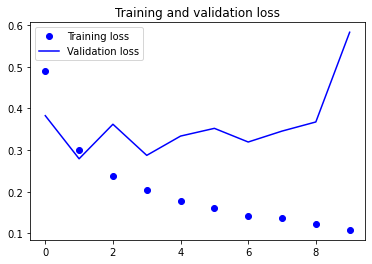

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation accuracy is a little bit better than SimpleRNN. But it is not ground-breakingly good.

### `LSTM` is good at analyzing global, long-term structure of the reviews. The strength of LSTM will become apparent: in particular, question-answering and machine translation.

### `LSTM` isn't helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each reviews, and at what frequency. The fully connected approach (that we looked at before) did exactly that.

